In [1]:
from pathlib import Path
import torch
from torch import nn, optim
from torch.nn import functional as F
import math
from mltools import models, draw, MachineLearning, Recorder, Accumulator
from d2l import torch as d2l

In [2]:
train_iter, vocab = d2l.load_data_time_machine(batch_size=32, num_steps=35)
rnn_layer = nn.LSTM(len(vocab), hidden_size=256, num_layers=1, batch_first=True)  # 定义循环网络LSTM
model = models.RNNModel(lambda x: F.one_hot(x, len(vocab)), rnn_layer, step_size=1, output_size=len(vocab))  # 定义训练模型
device = torch.device('cuda')


class LSTMTMMachineLearning(MachineLearning):
    def set_recorder(self):
        '''设置损失记录器'''
        self.recorder = Recorder(1)

    def set_animator(self, num_epochs):
        '''设置Animator'''
        rlim = num_epochs + self.recorder.max_record_size()  # 计算xlim的右边界
        self.animator = draw.Animator(xlabel='epoch', ylabel='perplexity', xlim=[0, rlim+1], ylim=-0.1)

    def train_epoch(self):
        '''一个迭代周期'''
        self.timer.start()
        self.calculate_train_iter()  # 计算训练集
        self.timer.stop()
        self.output_print()
        self.animator.show(self.recorder.data, legend=['train'])  # 添加损失值

    def calculate_train_iter(self):
        '''计算训练集'''
        metric = Accumulator(2)  # 累加器：(train_loss, train_size)
        self.model.train()  # 训练模式
        for x, y in self.train_iter:
            x = self.transform_x(x)  # 转换x
            y_train = self.calculate_model(x)  # 计算模型
            y = self.transform_y(y)  # 转换y
            y_train = self.transform_model_result(y_train)  # 转换模型结果
            train_loss = self.calculate_loss(y_train, y)  # 计算训练损失
            self.grad_update(train_loss)  # 梯度更新
            metric.add(train_loss * len(y), len(y))
        self.recorder[0].append(math.exp(metric[0] / metric[1]))

    def transform_y(self, y):
        '''转换y'''
        return y.reshape(-1).to(self.device)

    def calculate_model(self, x):
        '''计算神经网络'''
        y, _ = self.model(x)
        return y

    def grad_update(self, loss):
        '''梯度更新'''
        self.optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1, norm_type=2)
        self.optimizer.step()

    def output_print(self):
        '''打印输出值'''
        print(f'困惑度 {self.recorder[0][-1]:.3f}')
        print(f'{self.timer.sum() / self.num_epoch:.1f} sec/epoch on {str(self.device)}')

    def predict(self, prefix, num_preds=50):
        '''预测模型'''
        self.model.eval()  # 验证模式
        outputs = vocab[list(prefix)]
        state = None
        for y in prefix:  # 预热期
            _, state = model(torch.tensor([vocab[y]], device=device).reshape(1, 1), state)
        for _ in range(num_preds):  # 预测num_preds步
            y, state = model(torch.tensor([outputs[-1]], device=device).reshape(1, 1), state)
            outputs.append(int(y.argmax(dim=1).reshape(1)))
        print(''.join([vocab.idx_to_token[i] for i in outputs]))


ml = LSTMTMMachineLearning(model, train_iter, device=device)
model_path = '../model/LSTM_TM.pth'  # 模型保存路径

困惑度 1.389
0.1 sec/epoch on cuda


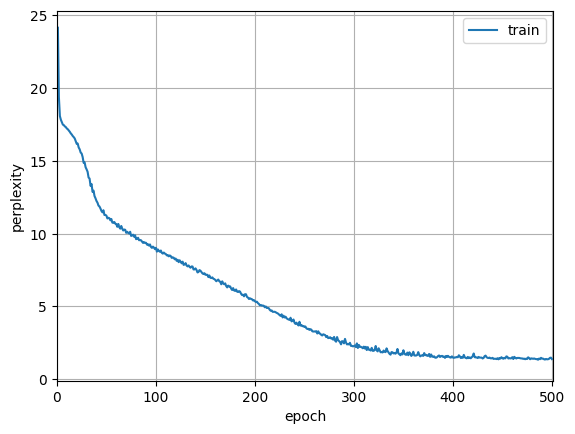

In [3]:
ml.set_loss(nn.CrossEntropyLoss())
ml.set_optimizer(optim.SGD(model.parameters(), lr=1))
if True:
    ml.train(num_epochs=500)  # 训练
    if True:
        torch.save(model.state_dict(), model_path)
elif Path(model_path).exists():
    model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))

In [4]:
ml.test()

Accuracy rate 0.906


In [5]:
ml.predict('time traveller ')

time traveller fo eepess hered nismps and direction of space and 
